In [1]:
import logging
import numpy as np
import csv

#from RSNAbreastCancer import *
#from .RSNAtestDataset import *

from torchvision import transforms
from torch.utils.data import DataLoader
import os
import torch
import random
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.util import random_noise

/home/zhemin/anaconda3/envs/vqvae_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/zhemin/anaconda3/envs/vqvae_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# load image

In [2]:
train_df = pd.read_csv('/home/zhemin/Datacenter_storage/zhemin/mammo_concat_csv/train_s3.csv')
train_df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,patient_id,study_id,label,noise,pixel_mean,pixel_std,min_p_count,max_p_count,img_path,view,id_view
0,0,1,1,9973,1.2.840.10009.1.2.3.9973,0,none,45,44,22966,12,/home/zhemin/Datacenter_storage/zhemin/mammo_c...,CC,9973CC
1,1,2,2,997,1.2.840.10009.1.2.3.997,0,none,34,45,34299,33,/home/zhemin/Datacenter_storage/zhemin/mammo_c...,CC,997CC
2,2,7,7,9954,1.2.840.10009.1.2.3.9954,0,none,44,45,27002,1,/home/zhemin/Datacenter_storage/zhemin/mammo_c...,CC,9954CC
3,3,8,8,9953,1.2.840.10009.1.2.3.9953,0,none,46,40,23526,4,/home/zhemin/Datacenter_storage/zhemin/mammo_c...,CC,9953CC
4,4,9,9,9949,1.2.840.10009.1.2.3.9949,0,none,39,39,25957,2,/home/zhemin/Datacenter_storage/zhemin/mammo_c...,CC,9949CC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11717,13994,11377,11377,10097,1.2.840.10009.1.2.3.10097,0,none,53,50,19507,1,/home/zhemin/Datacenter_storage/zhemin/mammo_c...,MLO,10097MLO
11718,13995,11378,11378,10095,1.2.840.10009.1.2.3.10095,0,none,45,50,27945,4,/home/zhemin/Datacenter_storage/zhemin/mammo_c...,MLO,10095MLO
11719,13996,11381,11381,10050,1.2.840.10009.1.2.3.10050,0,none,53,45,16476,1,/home/zhemin/Datacenter_storage/zhemin/mammo_c...,MLO,10050MLO
11720,13997,11382,11382,10049,1.2.840.10009.1.2.3.10049,0,none,54,54,21350,4,/home/zhemin/Datacenter_storage/zhemin/mammo_c...,MLO,10049MLO


In [3]:
def apply_round_mask(image, mask_size):
    _, h, w = image.size()

    # Calculate the radius of the circular mask (20% of the smaller dimension)
    radius = min(h, w) * mask_size / 2

    # Create a grid of coordinates
    x = torch.arange(w).float().view(1, -1)
    y = torch.arange(h).float().view(-1, 1)
    
    mask = torch.zeros(1, h, w)
    center = (h//2, w//2)
    #y, x= torch.ogrid[:h, :w]
    mask[0, (x-center[1])**2+(y-center[0])**2 <= radius**2] = 1
    #print("mask:", mask)
    mask = 1-mask
    print("mask shape:", mask.shape)

    mask_value = random.random()
    print("mask value:", mask_value)
    masked_image = image.clone()
    masked_image[mask==0] = mask_value


    return masked_image

In [4]:
def select_random_image(folder_path):
    # List all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('png'))]
    # Choose a random image from the list
    random_image = random.choice(image_files)
    return os.path.join(folder_path, random_image)

def resize_and_paste(original_image, random_image_path):
    x_pos = random.randint(0, 150)
    y_pos = random.randint(0, 150)
    print((x_pos, y_pos))
    random_image = Image.open(random_image_path)
    random_image = random_image.convert('L')
    random_image_resized = random_image.resize((120, 120))
    
    # Paste the resized random image onto the original image
    original_image.paste(random_image_resized, (x_pos, y_pos))
    
    return original_image

generate noise or not: 0


(-0.5, 255.5, 255.5, -0.5)

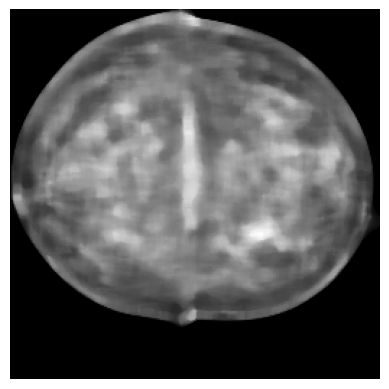

In [12]:
import torchvision.transforms.functional as tf
from skimage.util import random_noise
imgSize = 256

img = Image.open(train_df.iloc[0]['img_path'])
img = img.convert('L')
label = train_df['label'].iloc[0]
rotate_label = 0
invert_label = 0
colorJ_label = 0
mask_label = 0
natural_label = 0

noise_gen = random.randint(0, 0)
noise_int = 0
print("generate noise or not:", noise_gen)

img = img.filter(ImageFilter.MedianFilter(size=11))

if noise_gen == 1:
    noise_int = random.randint(1, 5)
    print("noise int random:", noise_int)

if noise_int == 1:
    randome_angle = random.uniform(-50, 50)
    img = tf.rotate(img=img, angle=randome_angle)
    rotate_label = 1
if noise_int == 2:
    img = tf.invert(img=img)
if noise_int == 3 :
    colorJ = transforms.ColorJitter(brightness=(2.0, 2.5), contrast=(0.7, 1.0), saturation=(0.5, 0.7), hue=0.5)
    img = colorJ(img)
if noise_int == 5:
    natural_p = select_random_image('./natural_tr/')
    print(natural_p)
    img = resize_and_paste(original_image=img, random_image_path=natural_p)

img = np.array(img)


# normalize images
img = (((img-np.min(img))/(np.max(img)-np.min(img)))*255).astype(dtype='uint8')
# if noise_int == 6:
#     img = random_noise(img, mode='poisson', clip=True)
#     print("img min and max:", np.min(img), np.max(img))
#     img = np.array(255*img, dtype='uint8')
#     print("img min and max:", np.min(img), np.max(img))

transformations = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Resize((imgSize,imgSize), antialias=True),
                                    #transforms.RandomRotation(degrees=(-15,15)),
                                    transforms.Normalize(mean=[0.5], std=[0.5])])
# print("RSNA img shape before transform:", img.shape)
resize_img = transformations(img)

resize_img = resize_img.to(torch.float32)
resize_img = (resize_img+1)/2
if noise_int == 4:
    resize_img = apply_round_mask(resize_img, mask_size=0.3)
    print("max pixel:", torch.max(resize_img))
    print("min pixel:", torch.min(resize_img))

resize_img = resize_img.reshape([256, 256, 1]).numpy()
plt.imshow(resize_img, cmap='gray')
plt.axis('off')